In [42]:
from pathlib import Path
from PIL import Image

# Convert lyft dataset to KITTI dataset

In [43]:
DATA_DIR = Path().absolute() 

In [44]:
# dir to write KITTY-style dataset
STORE_DIR = DATA_DIR.joinpath('kitti_format')
TABLES_DIR = DATA_DIR.joinpath('train_data')

In [45]:
DATA_DIR

PosixPath('/workspace/auto_driving/data/lyft_3d')

In [46]:
##############################################################
# kitty.py
##############################################################
# nuScenes dev-kit.
import os
from pathlib import Path
from typing import Any, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
from lyft_dataset_sdk.lyftdataset import LyftDatasetExplorer
from lyft_dataset_sdk.utils.data_classes import Box, LidarPointCloud
from lyft_dataset_sdk.utils.geometry_utils import BoxVisibility, box_in_image, view_points
from matplotlib.axes import Axes
from PIL import Image
from pyquaternion import Quaternion


class KittiDB:
    def __init__(self, root: Path):
        """
        :param root: Base folder for all KITTI data.
        """
        self.root = root
        self.tables = ("calib", "image_2", "label_2", "velodyne")
        self._kitti_fileext = {"calib": "txt", "image_2": "png", "label_2": "txt", "velodyne": "bin"}

        # Grab all the expected tokens.
        self._kitti_tokens = []

        split_dir = self.root.joinpath("image_2")
        _tokens = os.listdir(split_dir)
        _tokens = [t.replace(".png", "") for t in _tokens]
        _tokens.sort()
        self.tokens = _tokens

        # KITTI LIDAR has the x-axis pointing forward, but our LIDAR points to the right. So we need to apply a
        # 90 degree rotation around to yaw (z-axis) in order to align.
        # The quaternions will be used a lot of time. We store them as instance variables so that we don't have
        # to create a new one every single time.
        self.kitti_to_nu_lidar = Quaternion(axis=(0, 0, 1), angle=np.pi / 2)
        self.kitti_to_nu_lidar_inv = Quaternion(axis=(0, 0, 1), angle=np.pi / 2).inverse

    @staticmethod
    def parse_label_line(label_line) -> dict:
        """
        Parses single line from label file into a dict. Boxes are in camera frame. See KITTI devkit for details and
        http://www.cvlibs.net/datasets/kitti/setup.php for visualizations of the setup.
        :param label_line: Single line from KittiDB label file.
        :return: Dictionary with all the line details.
        """

        parts = label_line.split(" ")
        output = {
            "name": parts[0].strip(),
            "xyz_camera": (float(parts[11]), float(parts[12]), float(parts[13])),
            "wlh": (float(parts[9]), float(parts[10]), float(parts[8])),
            "yaw_camera": float(parts[14]),
            "bbox_camera": (float(parts[4]), float(parts[5]), float(parts[6]), float(parts[7])),
            "truncation": float(parts[1]),
            "occlusion": float(parts[2]),
            "alpha": float(parts[3]),
        }

        # Add score if specified
        if len(parts) > 15:
            output["score"] = float(parts[15])
        else:
            output["score"] = np.nan

        return output

    @staticmethod
    def box_nuscenes_to_kitti(
        box: Box,
        velo_to_cam_rot: Quaternion,
        velo_to_cam_trans: np.ndarray,
        r0_rect: Quaternion,
        kitti_to_nu_lidar_inv: Quaternion = Quaternion(axis=(0, 0, 1), angle=np.pi / 2).inverse,
    ) -> Box:
        """
        Transform from nuScenes lidar frame to KITTI reference frame.
        :param box: Instance in nuScenes lidar frame.
        :param velo_to_cam_rot: Quaternion to rotate from lidar to camera frame.
        :param velo_to_cam_trans: <np.float: 3>. Translate from lidar to camera frame.
        :param r0_rect: Quaternion to rectify camera frame.
        :param kitti_to_nu_lidar_inv: Quaternion to rotate nuScenes to KITTI LIDAR.
        :return: Box instance in KITTI reference frame.
        """
        # Copy box to avoid side-effects.
        box = box.copy()

        # Rotate to KITTI lidar.
        box.rotate(kitti_to_nu_lidar_inv)

        # Transform to KITTI camera.
        box.rotate(velo_to_cam_rot)
        box.translate(velo_to_cam_trans)

        # Rotate to KITTI rectified camera.
        box.rotate(r0_rect)

        # KITTI defines the box center as the bottom center of the object.
        # We use the true center, so we need to adjust half height in y direction.
        box.translate(np.array([0, box.wlh[2] / 2, 0]))

        return box

    @staticmethod
    def project_kitti_box_to_image(
        box: Box, p_left: np.ndarray, imsize: Tuple[int, int]
    ) -> Union[None, Tuple[int, int, int, int]]:
        """
        Projects 3D box into KITTI image FOV.
        :param box: 3D box in KITTI reference frame.
        :param p_left: <np.float: 3, 4>. Projection matrix.
        :param imsize: (width, height). Image size.
        :return: (xmin, ymin, xmax, ymax). Bounding box in image plane or None if box is not in the image.
        """

        # Create a new box.
        box = box.copy()

        # KITTI defines the box center as the bottom center of the object.
        # We use the true center, so we need to adjust half height in negative y direction.
        box.translate(np.array([0, -box.wlh[2] / 2, 0]))

        # Check that some corners are inside the image.
        corners = np.array([corner for corner in box.corners().T if corner[2] > 0]).T
        if len(corners) == 0:
            return None

        # Project corners that are in front of the camera to 2d to get bbox in pixel coords.
        imcorners = view_points(corners, p_left, normalize=True)[:2]
        bbox = (np.min(imcorners[0]), np.min(imcorners[1]), np.max(imcorners[0]), np.max(imcorners[1]))

        # Crop bbox to prevent it extending outside image.
        bbox_crop = tuple(max(0, b) for b in bbox)
        bbox_crop = (
            min(imsize[0], bbox_crop[0]),
            min(imsize[0], bbox_crop[1]),
            min(imsize[0], bbox_crop[2]),
            min(imsize[1], bbox_crop[3]),
        )

        # Detect if a cropped box is empty.
        if bbox_crop[0] >= bbox_crop[2] or bbox_crop[1] >= bbox_crop[3]:
            return None

        return bbox_crop

    @staticmethod
    def get_filepath(token: str, table: str, root: Path) -> str:
        """
        For a token and table, get the filepath to the associated data.
        :param token: KittiDB unique id.
        :param table: Type of table, for example image or velodyne.
        :param root: Base folder for all KITTI data.
        :return: Full get_filepath to desired data.
        """
        kitti_fileext = {"calib": "txt", "image_2": "png", "label_2": "txt", "velodyne": "bin"}

        ending = kitti_fileext[table]

        filepath = root.joinpath(table, "{}.{}".format(token, ending))

        return str(filepath)

    @staticmethod
    def get_transforms(token: str, root: Path) -> dict:
        calib_filename = KittiDB.get_filepath(token, "calib", root=root)

        lines = [line.rstrip() for line in open(calib_filename)]
        velo_to_cam = np.array(lines[5].strip().split(" ")[1:], dtype=np.float64)
        velo_to_cam.resize((3, 4))

        r0_rect = np.array(lines[4].strip().split(" ")[1:], dtype=np.float64)
        r0_rect.resize((3, 3))
        p_left = np.array(lines[2].strip().split(" ")[1:], dtype=np.float64)
        p_left.resize((3, 4))

        # Merge rectification and projection into one matrix.
        p_combined = np.eye(4)
        p_combined[:3, :3] = r0_rect
        p_combined = np.dot(p_left, p_combined)
        return {
            "velo_to_cam": {"R": velo_to_cam[:, :3], "T": velo_to_cam[:, 3]},
            "r0_rect": r0_rect,
            "p_left": p_left,
            "p_combined": p_combined,
        }

    @staticmethod
    def get_pointcloud(token: str, root: Path) -> LidarPointCloud:
        """
        Load up the pointcloud for a sample.
        :param token: KittiDB unique id.
        :param root: Base folder for all KITTI data.
        :return: LidarPointCloud for the sample in the KITTI Lidar frame.
        """
        pc_filename = KittiDB.get_filepath(token, "velodyne", root=root)

        # The lidar PC is stored in the KITTI LIDAR coord system.
        pc = LidarPointCloud(np.fromfile(pc_filename, dtype=np.float32).reshape(-1, 4).T)

        return pc

    def get_boxes(self, token: str, filter_classes: List[str] = None, max_dist: float = None) -> List[Box]:
        """
        Load up all the boxes associated with a sample.
        Boxes are in nuScenes lidar frame.
        :param token: KittiDB unique id.
        :param filter_classes: List of Kitti classes to use or None to use all.
        :param max_dist: Maximum distance in m to still draw a box.
        :return: Boxes in nuScenes lidar reference frame.
        """
        # Get transforms for this sample
        transforms = self.get_transforms(token, root=self.root)

        boxes = []
        if token.startswith("test_"):
            # No boxes to return for the test set.
            return boxes

        with open(KittiDB.get_filepath(token, "label_2", root=self.root), "r") as f:
            for line in f:
                # Parse this line into box information.
                parsed_line = self.parse_label_line(line)

                if parsed_line["name"] in {"DontCare", "Misc"}:
                    continue

                center = parsed_line["xyz_camera"]
                wlh = parsed_line["wlh"]
                yaw_camera = parsed_line["yaw_camera"]
                name = parsed_line["name"]
                score = parsed_line["score"]

                # Optional: Filter classes.
                if filter_classes is not None and name not in filter_classes:
                    continue

                # The Box class coord system is oriented the same way as as KITTI LIDAR: x forward, y left, z up.
                # For orientation confer: http://www.cvlibs.net/datasets/kitti/setup.php.

                # 1: Create box in Box coordinate system with center at origin.
                # The second quaternion in yaw_box transforms the coordinate frame from the object frame
                # to KITTI camera frame. The equivalent cannot be naively done afterwards, as it's a rotation
                # around the local object coordinate frame, rather than the camera frame.
                quat_box = Quaternion(axis=(0, 1, 0), angle=yaw_camera) * Quaternion(axis=(1, 0, 0), angle=np.pi / 2)
                box = Box([0.0, 0.0, 0.0], wlh, quat_box, name=name)

                # 2: Translate: KITTI defines the box center as the bottom center of the vehicle. We use true center,
                # so we need to add half height in negative y direction, (since y points downwards), to adjust. The
                # center is already given in camera coord system.
                box.translate(center + np.array([0, -wlh[2] / 2, 0]))

                # 3: Transform to KITTI LIDAR coord system. First transform from rectified camera to camera, then
                # camera to KITTI lidar.

                box.rotate(Quaternion(matrix=transforms["r0_rect"]).inverse)
                box.translate(-transforms["velo_to_cam"]["T"])
                box.rotate(Quaternion(matrix=transforms["velo_to_cam"]["R"]).inverse)
                # 4: Transform to nuScenes LIDAR coord system.
                box.rotate(self.kitti_to_nu_lidar)

                # Set score or NaN.
                box.score = score

                # Set dummy velocity.
                box.velocity = np.array((0.0, 0.0, 0.0))

                # Optional: Filter by max_dist
                if max_dist is not None:
                    dist = np.sqrt(np.sum(box.center[:2] ** 2))
                    if dist > max_dist:
                        continue

                boxes.append(box)

        return boxes

    def get_boxes_2d(
        self, token: str, filter_classes: List[str] = None
    ) -> Tuple[List[Tuple[float, float, float, float]], List[str]]:
        """
        Get the 2d boxes associated with a sample.
        :return: A list of boxes in KITTI format (xmin, ymin, xmax, ymax) and a list of the class names.
        """
        boxes = []
        names = []
        with open(KittiDB.get_filepath(token, "label_2", root=self.root), "r") as f:
            for line in f:
                # Parse this line into box information.
                parsed_line = self.parse_label_line(line)

                if parsed_line["name"] in {"DontCare", "Misc"}:
                    continue

                bbox_2d = parsed_line["bbox_camera"]
                name = parsed_line["name"]

                # Optional: Filter classes.
                if filter_classes is not None and name not in filter_classes:
                    continue

                boxes.append(bbox_2d)
                names.append(name)
        return boxes, names

    @staticmethod
    def box_to_string(
        name: str,
        box: Box,
        bbox_2d: Tuple[float, float, float, float] = (-1.0, -1.0, -1.0, -1.0),
        truncation: float = -1.0,
        occlusion: int = -1,
        alpha: float = -10.0,
    ) -> str:
        """
        Convert box in KITTI image frame to official label string fromat.
        :param name: KITTI name of the box.
        :param box: Box class in KITTI image frame.
        :param bbox_2d: Optional, 2D bounding box obtained by projected Box into image (xmin, ymin, xmax, ymax).
            Otherwise set to KITTI default.
        :param truncation: Optional truncation, otherwise set to KITTI default.
        :param occlusion: Optional occlusion, otherwise set to KITTI default.
        :param alpha: Optional alpha, otherwise set to KITTI default.
        :return: KITTI string representation of box.
        """
        # Convert quaternion to yaw angle.
        v = np.dot(box.rotation_matrix, np.array([1, 0, 0]))
        yaw = -np.arctan2(v[2], v[0])

        # Prepare output.
        name += " "
        trunc = "{:.2f} ".format(truncation)
        occ = "{:d} ".format(occlusion)
        a = "{:.2f} ".format(alpha)
        bb = "{:.2f} {:.2f} {:.2f} {:.2f} ".format(bbox_2d[0], bbox_2d[1], bbox_2d[2], bbox_2d[3])
        hwl = "{:.2} {:.2f} {:.2f} ".format(box.wlh[2], box.wlh[0], box.wlh[1])  # height, width, length.
        xyz = "{:.2f} {:.2f} {:.2f} ".format(box.center[0], box.center[1], box.center[2])  # x, y, z.
        y = "{:.2f}".format(yaw)  # Yaw angle.
        s = " {:.4f}".format(box.score)  # Classification score.

        output = name + trunc + occ + a + bb + hwl + xyz + y
        if ~np.isnan(box.score):
            output += s

        return output

    def project_pts_to_image(self, pointcloud: LidarPointCloud, token: str) -> np.ndarray:
        """
        Project lidar points into image.
        :param pointcloud: The LidarPointCloud in nuScenes lidar frame.
        :param token: Unique KITTI token.
        :return: <np.float: N, 3.> X, Y are points in image pixel coordinates. Z is depth in image.
        """

        # Copy and convert pointcloud.
        pc_image = LidarPointCloud(points=pointcloud.points.copy())
        pc_image.rotate(self.kitti_to_nu_lidar_inv)  # Rotate to KITTI lidar.

        # Transform pointcloud to camera frame.
        transforms = self.get_transforms(token, root=self.root)
        pc_image.rotate(transforms["velo_to_cam"]["R"])
        pc_image.translate(transforms["velo_to_cam"]["T"])

        # Project to image.
        depth = pc_image.points[2, :]
        points_fov = view_points(pc_image.points[:3, :], transforms["p_combined"], normalize=True)
        points_fov[2, :] = depth

        return points_fov

    def render_sample_data(
        self,
        token: str,
        sensor_modality: str = "lidar",
        with_anns: bool = True,
        axes_limit: float = 30,
        ax: Axes = None,
        view_3d: np.ndarray = np.eye(4),
        color_func: Any = None,
        augment_previous: bool = False,
        box_linewidth: int = 2,
        filter_classes: List[str] = None,
        max_dist: float = None,
        out_path: str = None,
        render_2d: bool = False,
    ) -> None:
        """
        Render sample data onto axis. Visualizes lidar in nuScenes lidar frame and camera in camera frame.
        :param token: KITTI token.
        :param sensor_modality: The modality to visualize, e.g. lidar or camera.
        :param with_anns: Whether to draw annotations.
        :param axes_limit: Axes limit for lidar data (measured in meters).
        :param ax: Axes onto which to render.
        :param view_3d: 4x4 view matrix for 3d views.
        :param color_func: Optional function that defines the render color given the class name.
        :param augment_previous: Whether to augment an existing plot (does not redraw pointcloud/image).
        :param box_linewidth: Width of the box lines.
        :param filter_classes: Optionally filter the classes to render.
        :param max_dist: Maximum distance in m to still draw a box.
        :param out_path: Optional path to save the rendered figure to disk.
        :param render_2d: Whether to render 2d boxes (only works for camera data).
        """
        # Default settings.
        if color_func is None:
            color_func = LyftDatasetExplorer.get_color

        boxes = self.get_boxes(token, filter_classes=filter_classes, max_dist=max_dist)  # In nuScenes lidar frame.

        if sensor_modality == "lidar":
            # Load pointcloud.
            pc = self.get_pointcloud(token, self.root)  # In KITTI lidar frame.
            pc.rotate(self.kitti_to_nu_lidar.rotation_matrix)  # In nuScenes lidar frame.
            # Alternative options:
            # depth = pc.points[1, :]
            # height = pc.points[2, :]
            intensity = pc.points[3, :]

            # Project points to view.
            points = view_points(pc.points[:3, :], view_3d, normalize=False)
            coloring = intensity

            if ax is None:
                _, ax = plt.subplots(1, 1, figsize=(9, 9))

            if not augment_previous:
                ax.scatter(points[0, :], points[1, :], c=coloring, s=1)
                ax.set_xlim(-axes_limit, axes_limit)
                ax.set_ylim(-axes_limit, axes_limit)

            if with_anns:
                for box in boxes:
                    color = np.array(color_func(box.name)) / 255
                    box.render(ax, view=view_3d, colors=(color, color, "k"), linewidth=box_linewidth)

        elif sensor_modality == "camera":
            im_path = KittiDB.get_filepath(token, "image_2", root=self.root)
            im = Image.open(im_path)

            if ax is None:
                _, ax = plt.subplots(1, 1, figsize=(16, 9))

            if not augment_previous:
                ax.imshow(im)
                ax.set_xlim(0, im.size[0])
                ax.set_ylim(im.size[1], 0)

            if with_anns:
                if render_2d:
                    # Use KITTI's 2d boxes.
                    boxes_2d, names = self.get_boxes_2d(token, filter_classes=filter_classes)
                    for box, name in zip(boxes_2d, names):
                        color = np.array(color_func(name)) / 255
                        ax.plot([box[0], box[0]], [box[1], box[3]], color=color, linewidth=box_linewidth)
                        ax.plot([box[2], box[2]], [box[1], box[3]], color=color, linewidth=box_linewidth)
                        ax.plot([box[0], box[2]], [box[1], box[1]], color=color, linewidth=box_linewidth)
                        ax.plot([box[0], box[2]], [box[3], box[3]], color=color, linewidth=box_linewidth)
                else:
                    # Project 3d boxes to 2d.
                    transforms = self.get_transforms(token, self.root)
                    for box in boxes:
                        # Undo the transformations in get_boxes() to get back to the camera frame.
                        box.rotate(self.kitti_to_nu_lidar_inv)  # In KITTI lidar frame.
                        box.rotate(Quaternion(matrix=transforms["velo_to_cam"]["R"]))
                        box.translate(transforms["velo_to_cam"]["T"])  # In KITTI camera frame, un-rectified.
                        box.rotate(Quaternion(matrix=transforms["r0_rect"]))  # In KITTI camera frame, rectified.

                        # Filter boxes outside the image (relevant when visualizing nuScenes data in KITTI format).
                        if not box_in_image(box, transforms["p_left"][:3, :3], im.size, vis_level=BoxVisibility.ANY):
                            continue

                        # Render.
                        color = np.array(color_func(box.name)) / 255
                        box.render(
                            ax,
                            view=transforms["p_left"][:3, :3],
                            normalize=True,
                            colors=(color, color, "k"),
                            linewidth=box_linewidth,
                        )
        else:
            raise ValueError("Unrecognized modality {}.".format(sensor_modality))

        ax.axis("off")
        ax.set_title(token)
        ax.set_aspect("equal")

        # Render to disk.
        plt.tight_layout()
        if out_path is not None:
            plt.savefig(out_path)

In [47]:
##############################################################
# export_kitty.py
##############################################################

from pathlib import Path
from typing import List, Optional

import fire
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed, parallel_backend
from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud
from lyft_dataset_sdk.utils.geometry_utils import BoxVisibility, transform_matrix
#from lyft_dataset_sdk.utils.kitti import KittiDB
from PIL import Image
from pyquaternion import Quaternion
from tqdm import tqdm


class KittiConverter:
    def __init__(self, store_dir: str = "~/lyft_kitti/train/"):
        """
        :param store_dir: Where to write the KITTI-style annotations.
        """
        self.store_dir = Path(store_dir).expanduser()

        # Create store_dir.
        if not self.store_dir.is_dir():
            self.store_dir.mkdir(parents=True)

    def nuscenes_gt_to_kitti(
        self,
        lyft_dataroot: str,
        table_folder: str,
        lidar_name: str = "LIDAR_TOP",
        get_all_detections: bool = False,
        parallel_n_jobs: int = 4,
        samples_count: Optional[int] = None,
    ) -> None:
        """
         Converts nuScenes GT fromatted annotations to KITTI format.
        :param lyft_dataroot: Where lyft dataset stored (root dir).
        :param table_folder: folder with tables (json files).
        :param lidar_name: Name of the lidar sensor.
            Only one lidar allowed at this moment.
        :param get_all_detections: If True, will write all
            bboxes in PointCloud and use only FrontCamera.
        :param parallel_n_jobs: Number of threads to parralel processing.
        :param samples_count: Number of samples to convert.
        """

        self.lyft_dataroot = lyft_dataroot
        self.table_folder = table_folder
        self.lidar_name = lidar_name
        self.get_all_detections = get_all_detections
        self.samples_count = samples_count
        self.parallel_n_jobs = parallel_n_jobs

        # Select subset of the data to look at.
        self.lyft_ds = LyftDataset(self.lyft_dataroot, self.table_folder)

        self.kitti_to_nu_lidar = Quaternion(axis=(0, 0, 1), angle=np.pi / 2)
        self.kitti_to_nu_lidar_inv = self.kitti_to_nu_lidar.inverse

        # Get assignment of scenes to splits.
        split_logs = [self.lyft_ds.get("log", scene["log_token"])["logfile"] for scene in self.lyft_ds.scene]
        if self.get_all_detections:
            self.cams_to_see = ["CAM_FRONT"]
        else:
            self.cams_to_see = [
                "CAM_FRONT",
                "CAM_FRONT_LEFT",
                "CAM_FRONT_RIGHT",
                "CAM_BACK",
                "CAM_BACK_LEFT",
                "CAM_BACK_RIGHT",
            ]

        # Create output folders.
        self.label_folder = self.store_dir.joinpath("label_2")
        self.calib_folder = self.store_dir.joinpath("calib")
        self.image_folder = self.store_dir.joinpath("image_2")
        self.lidar_folder = self.store_dir.joinpath("velodyne")
        for folder in [self.label_folder, self.calib_folder, self.image_folder, self.lidar_folder]:
            if not folder.is_dir():
                folder.mkdir(parents=True)

        # Use only the samples from the current split.
        sample_tokens = self._split_to_samples(split_logs)
        if self.samples_count is not None:
            sample_tokens = sample_tokens[: self.samples_count]

        with parallel_backend("threading", n_jobs=self.parallel_n_jobs):
            Parallel()(delayed(self.process_token_to_kitti)(sample_token) for sample_token in tqdm(sample_tokens))

    def process_token_to_kitti(self, sample_token: str) -> None:
        # Get sample data.
        sample = self.lyft_ds.get("sample", sample_token)
        sample_annotation_tokens = sample["anns"]

        lidar_token = sample["data"][self.lidar_name]
        sd_record_lid = self.lyft_ds.get("sample_data", lidar_token)
        cs_record_lid = self.lyft_ds.get("calibrated_sensor", sd_record_lid["calibrated_sensor_token"])
        for cam_name in self.cams_to_see:
            cam_front_token = sample["data"][cam_name]
            if self.get_all_detections:
                token_to_write = sample_token
            else:
                token_to_write = cam_front_token

            # Retrieve sensor records.
            sd_record_cam = self.lyft_ds.get("sample_data", cam_front_token)
            cs_record_cam = self.lyft_ds.get("calibrated_sensor", sd_record_cam["calibrated_sensor_token"])
            cam_height = sd_record_cam["height"]
            cam_width = sd_record_cam["width"]
            imsize = (cam_width, cam_height)

            # Combine transformations and convert to KITTI format.
            # Note: cam uses same conventions in KITTI and nuScenes.
            lid_to_ego = transform_matrix(
                cs_record_lid["translation"], Quaternion(cs_record_lid["rotation"]), inverse=False
            )
            ego_to_cam = transform_matrix(
                cs_record_cam["translation"], Quaternion(cs_record_cam["rotation"]), inverse=True
            )
            velo_to_cam = np.dot(ego_to_cam, lid_to_ego)

            # Convert from KITTI to nuScenes LIDAR coordinates, where we apply velo_to_cam.
            velo_to_cam_kitti = np.dot(velo_to_cam, self.kitti_to_nu_lidar.transformation_matrix)

            # Currently not used.
            imu_to_velo_kitti = np.zeros((3, 4))  # Dummy values.
            r0_rect = Quaternion(axis=[1, 0, 0], angle=0)  # Dummy values.

            # Projection matrix.
            p_left_kitti = np.zeros((3, 4))
            # Cameras are always rectified.
            p_left_kitti[:3, :3] = cs_record_cam["camera_intrinsic"]

            # Create KITTI style transforms.
            velo_to_cam_rot = velo_to_cam_kitti[:3, :3]
            velo_to_cam_trans = velo_to_cam_kitti[:3, 3]

            # Check that the rotation has the same format as in KITTI.
            assert (velo_to_cam_trans[1:3] < 0).all()

            # Retrieve the token from the lidar.
            # Note that this may be confusing as the filename of the camera will
            # include the timestamp of the lidar,
            # not the camera.
            filename_cam_full = sd_record_cam["filename"]
            filename_lid_full = sd_record_lid["filename"]

            # Convert image (jpg to png).
            src_im_path = self.lyft_ds.data_path.joinpath(filename_cam_full)
            dst_im_path = self.image_folder.joinpath("{}.png".format(token_to_write))
            if not dst_im_path.exists():
                im = Image.open(src_im_path)
                im.save(dst_im_path, "PNG")

            # Convert lidar.
            # Note that we are only using a single sweep, instead of the commonly used n sweeps.
            src_lid_path = self.lyft_ds.data_path.joinpath(filename_lid_full)
            dst_lid_path = self.lidar_folder.joinpath("{}.bin".format(token_to_write))

            pcl = LidarPointCloud.from_file(Path(src_lid_path))
            # In KITTI lidar frame.
            pcl.rotate(self.kitti_to_nu_lidar_inv.rotation_matrix)
            with open(dst_lid_path, "w") as lid_file:
                pcl.points.T.tofile(lid_file)

            # Add to tokens.
            # tokens.append(token_to_write)

            # Create calibration file.
            kitti_transforms = dict()
            kitti_transforms["P0"] = np.zeros((3, 4))  # Dummy values.
            kitti_transforms["P1"] = np.zeros((3, 4))  # Dummy values.
            kitti_transforms["P2"] = p_left_kitti  # Left camera transform.
            kitti_transforms["P3"] = np.zeros((3, 4))  # Dummy values.
            # Cameras are already rectified.
            kitti_transforms["R0_rect"] = r0_rect.rotation_matrix
            kitti_transforms["Tr_velo_to_cam"] = np.hstack((velo_to_cam_rot, velo_to_cam_trans.reshape(3, 1)))
            kitti_transforms["Tr_imu_to_velo"] = imu_to_velo_kitti
            calib_path = self.calib_folder.joinpath("{}.txt".format(token_to_write))

            with open(calib_path, "w") as calib_file:
                for (key, val) in kitti_transforms.items():
                    val = val.flatten()
                    val_str = "%.12e" % val[0]
                    for v in val[1:]:
                        val_str += " %.12e" % v
                    calib_file.write("%s: %s\n" % (key, val_str))

            # Write label file.
            label_path = self.label_folder.joinpath("{}.txt".format(token_to_write))
            if label_path.exists():
                print("Skipping existing file: %s" % label_path)
                continue
            with open(label_path, "w") as label_file:
                for sample_annotation_token in sample_annotation_tokens:
                    sample_annotation = self.lyft_ds.get("sample_annotation", sample_annotation_token)

                    # Get box in LIDAR frame.
                    _, box_lidar_nusc, _ = self.lyft_ds.get_sample_data(
                        lidar_token, box_vis_level=BoxVisibility.NONE, selected_anntokens=[sample_annotation_token]
                    )
                    box_lidar_nusc = box_lidar_nusc[0]

                    # Truncated: Set all objects to 0 which means untruncated.
                    truncated = 0.0

                    # Occluded: Set all objects to full visibility as this information is
                    # not available in nuScenes.
                    occluded = 0

                    detection_name = sample_annotation["category_name"]

                    # Convert from nuScenes to KITTI box format.
                    box_cam_kitti = KittiDB.box_nuscenes_to_kitti(
                        box_lidar_nusc, Quaternion(matrix=velo_to_cam_rot), velo_to_cam_trans, r0_rect
                    )

                    # Project 3d box to 2d box in image, ignore box if it does not fall inside.
                    bbox_2d = KittiDB.project_kitti_box_to_image(box_cam_kitti, p_left_kitti, imsize=imsize)
                    if bbox_2d is None and not self.get_all_detections:
                        continue
                    elif bbox_2d is None and self.get_all_detections:
                        # default KITTI bbox
                        bbox_2d = (-1.0, -1.0, -1.0, -1.0)

                    # Set dummy score so we can use this file as result.
                    box_cam_kitti.score = 0

                    # Convert box to output string format.
                    output = KittiDB.box_to_string(
                        name=detection_name,
                        box=box_cam_kitti,
                        bbox_2d=bbox_2d,
                        truncation=truncated,
                        occlusion=occluded,
                    )

                    # Write to disk.
                    label_file.write(output + "\n")

    def render_kitti(self, render_2d: bool = False) -> None:
        """
        Renders the annotations in the KITTI dataset from a lidar and a camera view.
        :param render_2d: Whether to render 2d boxes (only works for camera data).
        """
        if render_2d:
            print("Rendering 2d boxes from KITTI format")
        else:
            print("Rendering 3d boxes projected from 3d KITTI format")

        # Load the KITTI dataset.
        kitti = KittiDB(root=self.store_dir)

        # Create output folder.
        render_dir = self.store_dir.joinpath("render")
        if not render_dir.is_dir():
            render_dir.mkdir(parents=True)

        # Render each image.
        tokens = kitti.tokens

        # currently supports only single thread processing
        for token in tqdm(tokens):

            for sensor in ["lidar", "camera"]:
                out_path = render_dir.joinpath("{}_{}.png".format(token, sensor))
                kitti.render_sample_data(token, sensor_modality=sensor, out_path=out_path, render_2d=render_2d)
                # Close the windows to avoid a warning of too many open windows.
                plt.close()

    def _split_to_samples(self, split_logs: List[str]) -> List[str]:
        """
        Convenience function to get the samples in a particular split.
        :param split_logs: A list of the log names in this split.
        :return: The list of samples.
        """
        samples = []
        for sample in self.lyft_ds.sample:
            scene = self.lyft_ds.get("scene", sample["scene_token"])
            log = self.lyft_ds.get("log", scene["log_token"])
            logfile = log["logfile"]
            if logfile in split_logs:
                samples.append(sample["token"])
        return samples


# if __name__ == "__main__":
#     fire.Fire(KittiConverter)

In [48]:
export_kitti = KittiConverter(store_dir=STORE_DIR)

In [49]:
# convertation to KITTY-format
export_kitti.nuscenes_gt_to_kitti(lyft_dataroot=DATA_DIR, table_folder=TABLES_DIR, 
                                  samples_count=20, parallel_n_jobs=2, 
                                 get_all_detections=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 11.4 seconds.
Reverse indexing ...


 40%|████      | 8/20 [00:00<00:00, 72.83it/s]

Done reverse indexing in 4.1 seconds.
Skipping existing file: /workspace/auto_driving/data/lyft_3d/kitti_format/label_2/b98a05255ba2632e957884758cb31f0e6fcc8d3cd6ee76b6d0ba55b72f08fc54.txt
Skipping existing file: /workspace/auto_driving/data/lyft_3d/kitti_format/label_2/095d5bb88eb9cdd223b90d2a1475c0cf2f4b4c2a8aca82ba0ae51f6fba540440.txt
Skipping existing file: /workspace/auto_driving/data/lyft_3d/kitti_format/label_2/78ce15b2b7360b8cd696d1097c60ec2184b69c17412564893b17694d1aebd816.txt
Skipping existing file: /workspace/auto_driving/data/lyft_3d/kitti_format/label_2/c2f0b2b2c0d576d42eab6e8703c4eacd302a79d4d702bdfee85268a20d4b6d1f.txt
Skipping existing file: /workspace/auto_driving/data/lyft_3d/kitti_format/label_2/f59c9f22016b783c6a7e5225fc56fccaf4fe3df4a9d96c27d9e51ba7ccfdca74.txt
Skipping existing file: /workspace/auto_driving/data/lyft_3d/kitti_format/label_2/375d6d3e731e97565c123ff2d632302abb54416eb8f9246c0a33797f0a4a97bb.txt
Skipping existing file: /workspace/auto_driving/data/lyf

100%|██████████| 20/20 [00:00<00:00, 61.50it/s]

Skipping existing file: /workspace/auto_driving/data/lyft_3d/kitti_format/label_2/f7fca7320eaf90ffc6d20bf5477a18ca61c042979eaaf0cda36603e1a969dad9.txt
Skipping existing file: /workspace/auto_driving/data/lyft_3d/kitti_format/label_2/3c25e76d834617e6b8d3bab816afe171e5f776d9f01a7dc6bbe10ea0ca2bd319.txt
Skipping existing file: /workspace/auto_driving/data/lyft_3d/kitti_format/label_2/350b18c3d099f4e6bff6a2c893a4fe34c49be64c762fdb6aabab335f6e759654.txt
Skipping existing file: /workspace/auto_driving/data/lyft_3d/kitti_format/label_2/9dd2165290d8ee5e3b16d15a531c157cfa2f564d36c596582422c3edaddfe890.txt
Skipping existing file: /workspace/auto_driving/data/lyft_3d/kitti_format/label_2/94334feafcb3c1a61845dc4fb461e01e36cc29aee438b660cc0574ec442abf24.txt
Skipping existing file: /workspace/auto_driving/data/lyft_3d/kitti_format/label_2/e76171b1f8c7bd4b5dc6b3cab99362fe08f96e6512a03bac13fffa7859e20664.txt
Skipping existing file: /workspace/auto_driving/data/lyft_3d/kitti_format/label_2/098ed5e4f46f


Skipping existing file: /workspace/auto_driving/data/lyft_3d/kitti_format/label_2/9364a9522aab79bc76aa20c83f0193241d6404071ca8e0f5024fd89db6576313.txt


In [50]:
# check created (converted) files. velodyne = LiDAR poinclouds data (in binary)
!ls {STORE_DIR}/velodyne | head -2

095d5bb88eb9cdd223b90d2a1475c0cf2f4b4c2a8aca82ba0ae51f6fba540440.bin
098ed5e4f46ffb242312eee1c9cfd47390bd1c91f5eb0189380ef429c00b40eb.bin


In [51]:
# render converted data for check. Currently don't support multithreading :(
export_kitti.render_kitti() 

  0%|          | 0/20 [00:00<?, ?it/s]

Rendering 3d boxes projected from 3d KITTI format


100%|██████████| 20/20 [00:47<00:00,  2.10s/it]


In [52]:
# Script above write images to 'render' folder
# in store_dir (where we have converted dataset)
RENDER_DIR = STORE_DIR.joinpath('render')

In [53]:
# get all rendered files
all_renders = list(RENDER_DIR.glob('*'))
all_renders.sort()

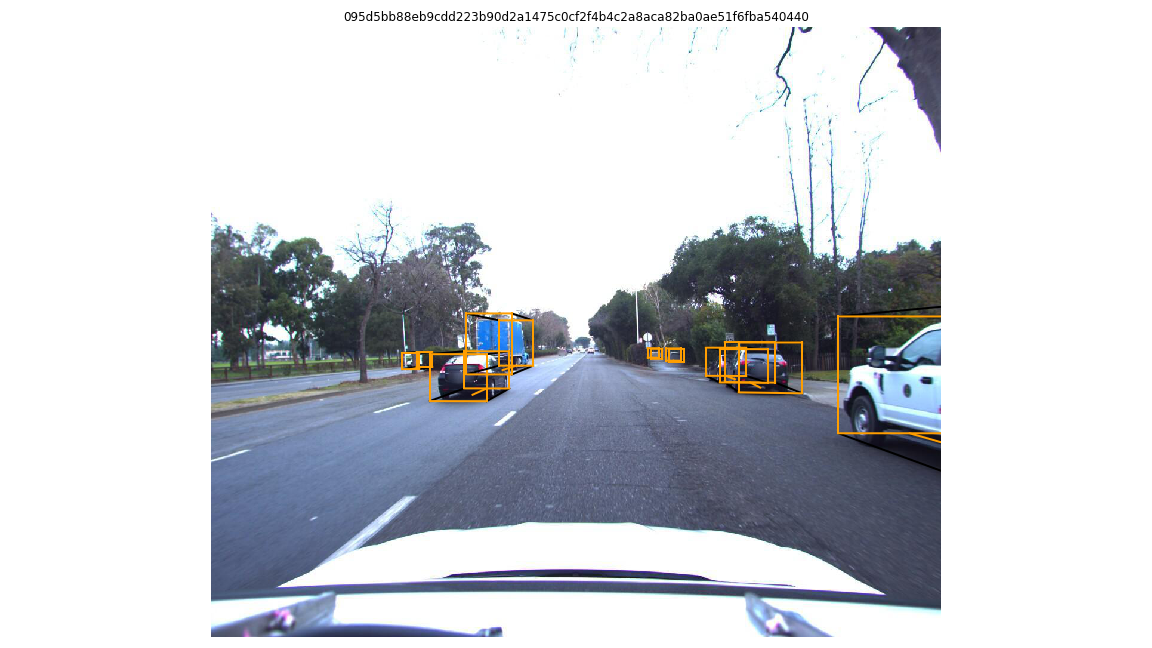

In [40]:
# render radar data (bird view) and camera data with bboxes
Image.open(all_renders[0])

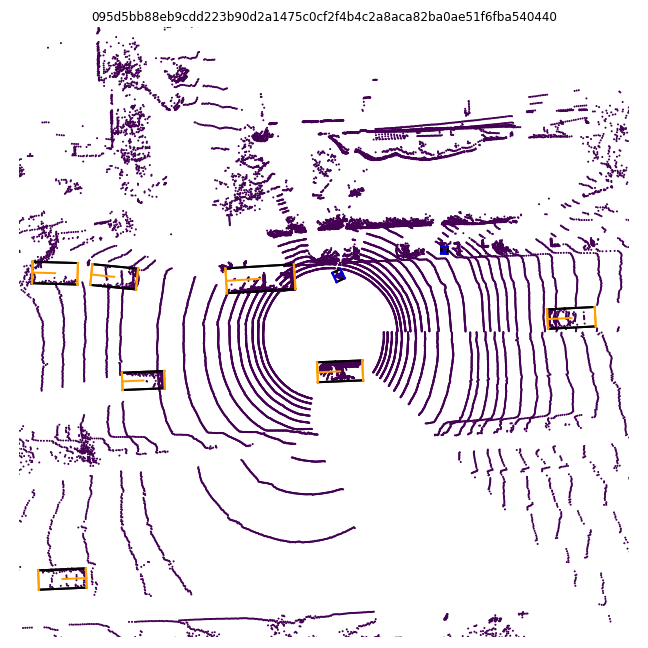

In [41]:
Image.open(all_renders[1])